### Take a look at the axes from all the value GLMs, see if they're similar

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

### Combine all GLM results in one

In [3]:
def get_glm_res(session, feedback_type, residual_str):
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, f"{session}_glm_{feedback_type}_{residual_str}_{EVENT}_{MODE}_{INTERVAL_SIZE}_{MODEL}_values.pickle"))
    res["TimeIdxs"] = (res["TimeBins"] * 20).astype(int)
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID
    return res

### Look at norm lengths of weight vectors as a func of time: 

In [4]:
fbs = ["Response", "RPEGroup"]
residual_strs = ["residual_fr", "normal_fr"]
glms = {}
for feedback_type in fbs:
    for residual_str in residual_strs:
        glm_res = pd.concat(sessions.apply(lambda x: get_glm_res(x.session_name, feedback_type, residual_str), axis=1).values)
        # glm_res = glm_res[glm_res.session == "20180802"]
        glms[f"{feedback_type}_{residual_str}"] = glm_res

### Correlations cared about: 
- Between residual vs normal: Response residual vs. Response normal, RPEGroup residual vs. RPEGroup normal
- Between Response vs. RPEGroup: Response residual vs. RPEGroup residual, Response normal vs. RPEGroup normal

In [7]:
pairs = [
    ("Response_residual_fr", "Response_normal_fr"),
    ("RPEGroup_residual_fr", "RPEGroup_normal_fr"),
    ("Response_residual_fr", "RPEGroup_residual_fr"),
    ("Response_normal_fr", "RPEGroup_normal_fr")
]

# each res is np arr [num_time_bins, num_feats]
num_time_bins = 20
num_feats = 12
pair_res = {}
for (cond_a, cond_b) in pairs:
    corrs = np.empty((num_time_bins, num_feats))
    for time_bin in range(num_time_bins):
        for feat_idx in range(num_feats):
            feat = FEATURES[feat_idx]
            glm_res_a = glms[cond_a]
            glm_res_b = glms[cond_b]
            vec_a = glm_res_a[glm_res_a.TimeIdxs == time_bin].sort_values(by="PseudoUnitID")[feat + "Value_coef"].values
            vec_b = glm_res_b[glm_res_b.TimeIdxs == time_bin].sort_values(by="PseudoUnitID")[feat + "Value_coef"].values
            corr = np.corrcoef(vec_a, vec_b)[0, 1]
            corrs[time_bin, feat_idx] = corr
    pair_res[(cond_a, cond_b)] = corrs

Text(0.5, 0, 'Time Relative to Feedback (s)')

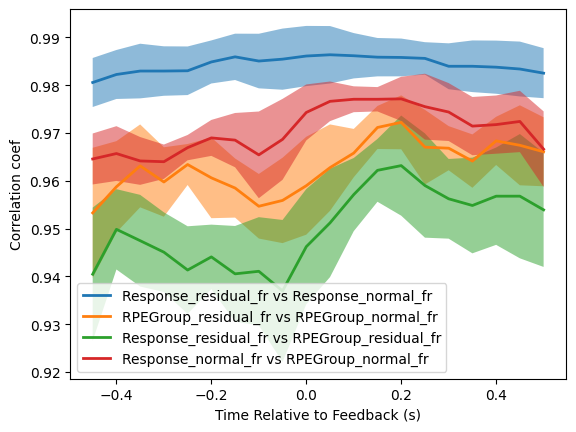

In [9]:
fig, ax = plt.subplots()
for pair in pairs:
    cors = pair_res[pair]
    visualization_utils.visualize_accuracy_across_time_bins(
        cors, 
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{pair[0]} vs {pair[1]}",
        right_align=True
    )
ax.legend()
ax.set_ylabel("Correlation coef")
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")

### How stable are the axes across time?

In [10]:
positions = spike_utils.get_unit_positions(sessions)

In [11]:
positions.structure_level2.unique()

array(['lateral_and_ventral_pallium (LVPal)',
       'lateral_prefrontal_cortex (lat_PFC)',
       'primary_visual_cortex (V1)', 'anterior_cingulate_gyrus (ACgG)',
       'posterior_medial_cortex (PMC)', 'orbital_frontal_cortex (OFC)',
       'unknown', 'basal_ganglia (BG)', 'inferior_temporal_cortex (ITC)',
       'motor_cortex (motor)', 'preoptic_complex (POC)', 'amygdala (Amy)',
       'extrastriate_visual_areas_2-4 (V2-V4)', 'medial_pallium (MPal)',
       'thalamus (Thal)', 'inferior_parietal_lobule (IPL)',
       'superior_parietal_lobule (SPL)',
       'floor_of_the_lateral_sulcus (floor_of_ls)',
       'medial_temporal_lobe (MTL)'], dtype=object)

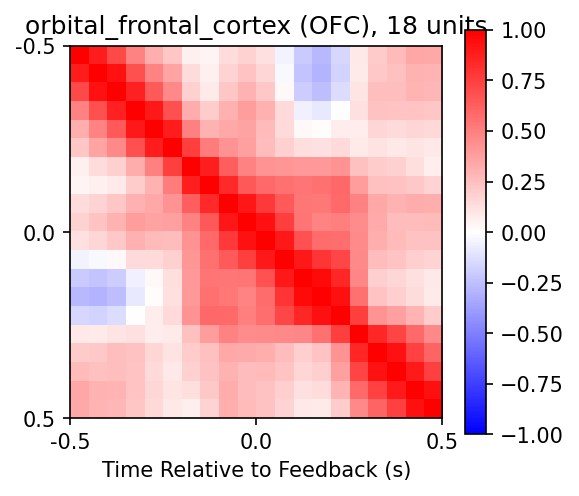

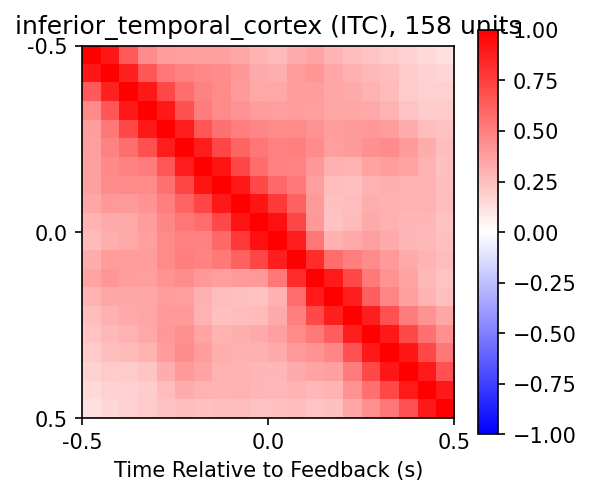

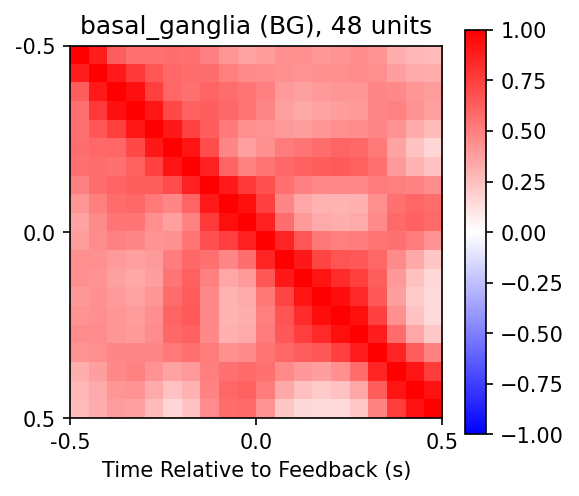

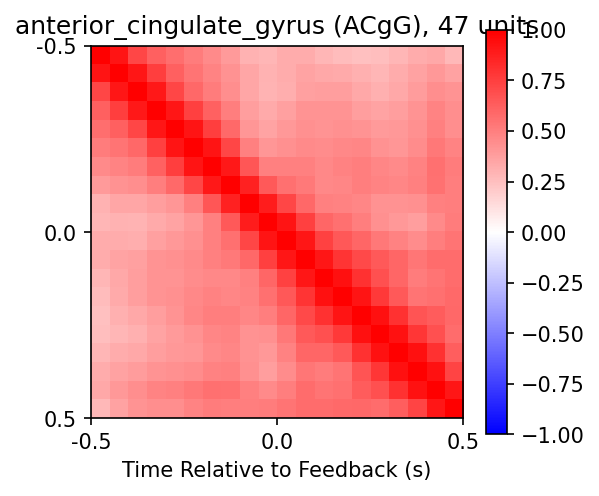

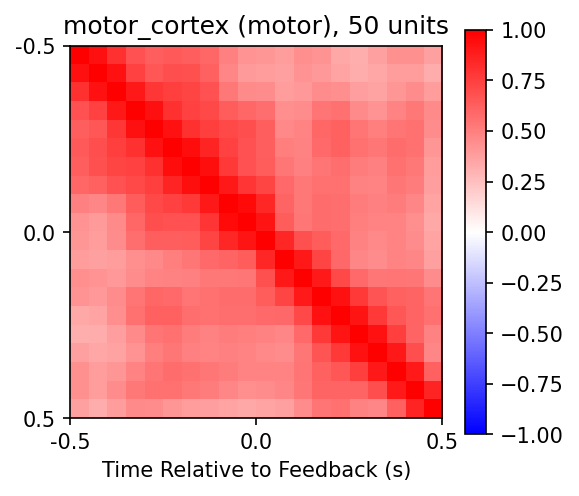

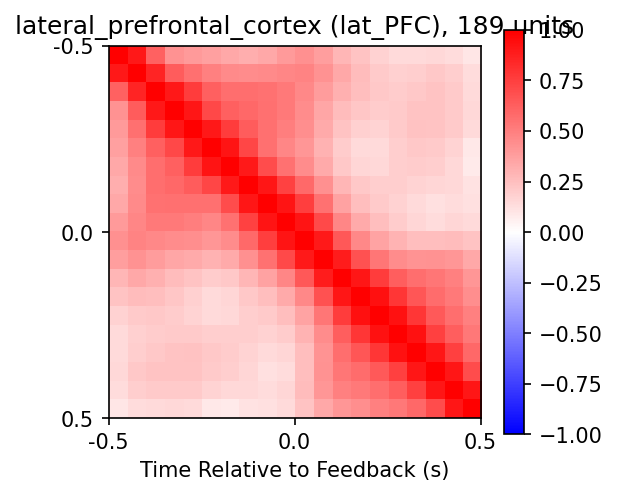

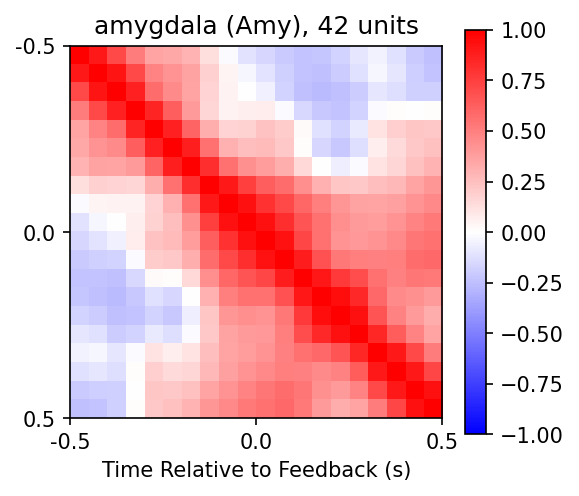

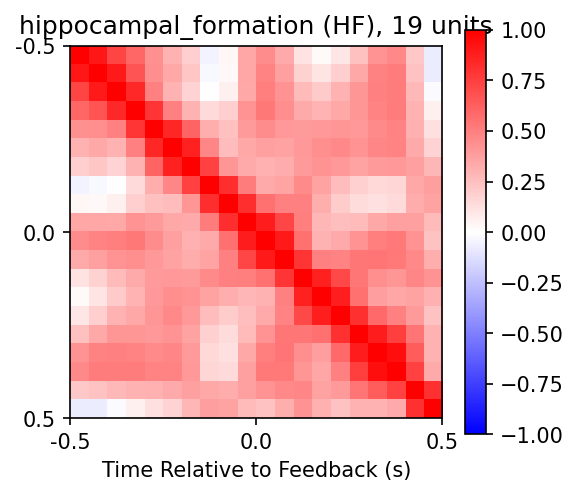

In [13]:
model = "RPEGroup_normal_fr"
interesting_regions = [
    ("structure_level2", "orbital_frontal_cortex (OFC)"),
    ("structure_level2", "inferior_temporal_cortex (ITC)"),
    ("structure_level2", "basal_ganglia (BG)"),
    ("structure_level2", "anterior_cingulate_gyrus (ACgG)"),
    ("structure_level2", "motor_cortex (motor)"),
    ("structure_level2", "lateral_prefrontal_cortex (lat_PFC)"),
    ("structure_level2", "amygdala (Amy)"),
    ("structure_level3", "hippocampal_formation (HF)"),
]
# # region_units = positions[positions.manual_structure == "Hippocampus/MTL"].PseudoUnitID
# # region_units = positions[positions.structure_level3 == "hippocampal_formation (HF)"].PseudoUnitID
# # region_units = positions[positions.structure_level2 == "orbital_frontal_cortex (OFC)"].PseudoUnitID
# region_units = positions[positions.structure_level2 == "orbital_frontal_cortex (OFC)"].PseudoUnitID
for level, region_name in interesting_regions:
    region_units = positions[positions[level] == region_name].PseudoUnitID
    glm_res = glms[model]
    glm_res = glm_res[glm_res.PseudoUnitID.isin(region_units)]

    cross_time_cors = np.empty((num_time_bins, num_time_bins))
    for time_i in range(num_time_bins):
        for time_j in range(num_time_bins):
            corrs = []
            for feat_idx in range(num_feats):
                feat = FEATURES[feat_idx]
                vec_i = glm_res[glm_res.TimeIdxs == time_i].sort_values(by="PseudoUnitID")[feat + "Value_coef"].values
                vec_j = glm_res[glm_res.TimeIdxs == time_j].sort_values(by="PseudoUnitID")[feat + "Value_coef"].values
                corr = np.corrcoef(vec_i, vec_j)[0, 1]
                corrs.append(corr)
            cross_time_cors[time_i, time_j] = np.mean(corrs)
            
    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150)
    # for i in range(num_time_bins):
    #     cross_time_cors[i, i] = 0
    colors = ax.matshow(cross_time_cors, cmap="bwr")
    fig.colorbar(colors)
    colors.set_clim(vmin=-1, vmax=1)
    ratio = 1000 / 50
    # tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
    tick_labels = np.array([-0.5, 0, 0.5])
    tick_pos = (tick_labels + 0.5) * ratio - 0.5
    # ax.axvline(27.46, color="gray", linestyle="dotted", linewidth=2)
    # ax.axhline(27.46, color="gray", linestyle="dotted", linewidth=2)
    # ax.axvline(9.5, color="gray", linestyle="dotted", linewidth=2)
    # ax.axhline(9.5, color="gray", linestyle="dotted", linewidth=2)
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_labels)
    num_units = len(region_units)
    ax.set_title(f"{region_name}, {num_units} units")
    ax.set_xlabel("Time Relative to Feedback (s)")
    
# glm_res = glm_res[glm_res.session == "20180802"]

In [70]:
glm_res = glms[model]
cross_time_cors = np.empty((num_time_bins, num_time_bins))
for time_i in range(num_time_bins):
    for time_j in range(num_time_bins):
        corrs = []
        for feat_idx in range(num_feats):
            feat = FEATURES[feat_idx]
            vec_i = glm_res[glm_res.TimeIdxs == time_i].sort_values(by="PseudoUnitID")[feat + "Value_coef"].values
            vec_j = glm_res[glm_res.TimeIdxs == time_j].sort_values(by="PseudoUnitID")[feat + "Value_coef"].values
            corr = np.corrcoef(vec_i, vec_j)[0, 1]
            corrs.append(corr)
        cross_time_cors[time_i, time_j] = np.mean(corrs)

Text(0.5, 0, 'Time Relative to Feedback (s)')

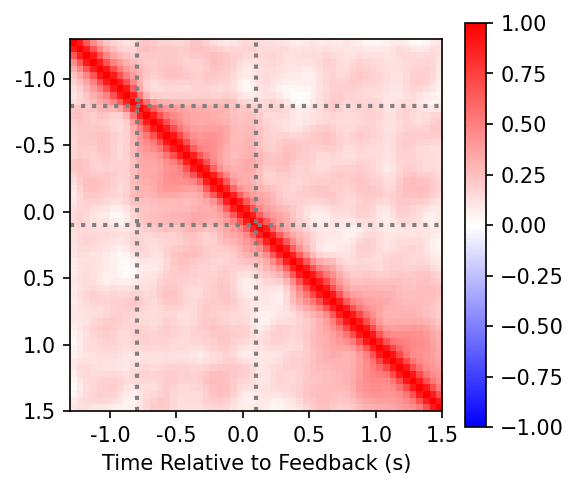

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=150)
# for i in range(num_time_bins):
#     cross_time_cors[i, i] = 0
colors = ax.matshow(cross_time_cors, cmap="bwr")
fig.colorbar(colors)
colors.set_clim(vmin=-1, vmax=1)
ratio = 1000 / 50
tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
tick_pos = (tick_labels + 1.3) * ratio - 0.5
ax.axvline(27.46, color="gray", linestyle="dotted", linewidth=2)
ax.axhline(27.46, color="gray", linestyle="dotted", linewidth=2)
ax.axvline(9.5, color="gray", linestyle="dotted", linewidth=2)
ax.axhline(9.5, color="gray", linestyle="dotted", linewidth=2)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.set_yticks(tick_pos)
ax.set_yticklabels(tick_labels)
ax.set_xlabel("Time Relative to Feedback (s)")


### Project some neural activity to value axes

In [5]:
sess_name = "20180712"

In [6]:
time = 1
time_idx = int((time + 1.3) * 20)
feat = "TRIANGLE"
feat_dim = FEATURE_TO_DIM[feat]
glm_res = glms["RPEGroup_normal_fr"]
glm_res = glm_res[glm_res.session == sess_name]
vec = glm_res[glm_res.TimeIdxs == time_idx].sort_values(by="UnitID")[feat + "Value_coef"].values

In [7]:
time_idx

46

In [8]:
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_{num_bins_smooth}_smooth.pickle"
spikes_path = SESS_SPIKES_PATH.format(
    sess_name=sess_name,
    pre_interval=PRE_INTERVAL,
    event=EVENT,
    post_interval=POST_INTERVAL,
    interval_size=INTERVAL_SIZE,
    num_bins_smooth=NUM_BINS_SMOOTH,
)
frs = pd.read_pickle(spikes_path)
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
beh = pd.read_csv(behavior_path)
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber")

In [9]:
valid_beh[valid_beh.CurrentRule == feat].BlockNumber.unique()

array([4])

In [10]:
block_number = 27
block = valid_beh[valid_beh.BlockNumber == block_number]
block = block[block[feat_dim] == feat]
block["TrialInBlock"] = range(len(block))



In [6]:
def project_to_axes(frs, vec, mode="FiringRate"):
    """
    For each Trial, Timebin, projects activity onto population vector
    Number of units must match vector length
    returns df of TrialNumber, TimeBins, projection
    """
    def project_vec(group):
        assert len(group) == len(vec)
        group = group.sort_values(by="UnitID")
        proj = np.dot(group[mode], vec)
        return pd.Series({"projection": proj})
        # return proj
    return frs.groupby(["TrialNumber", "TimeBins"]).apply(project_vec).reset_index()


In [ ]:
block_frs = frs[frs.TrialNumber.isin(block.TrialNumber)]
projections = project_to_axes(block_frs, vec)

In [ ]:
merged = pd.merge(projections, block, on="TrialNumber")

In [22]:
num_trials_in_block = len(merged.TrialNumber.unique())
alphas = np.arange(0.3, 1, (1 - 0.3) / num_trials_in_block)

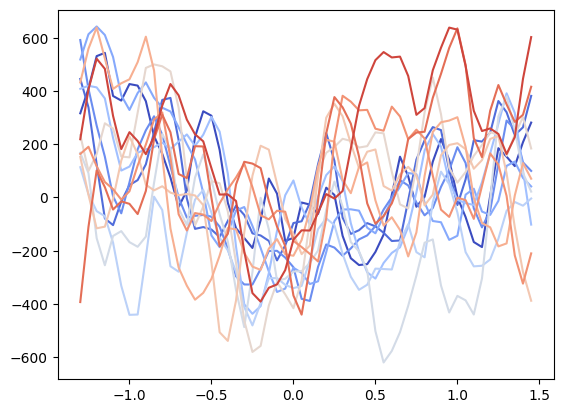

In [23]:
from matplotlib import cm
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(block))

fig, ax = plt.subplots()
for i in range(num_trials_in_block):
    projs = merged[merged.TrialInBlock == i]
    alpha = alphas[i]
    ax.plot(projs.TimeBins - 1.3, projs.projection, color=cm.coolwarm(norm(i)))

### Plot average feature value projection magnitude by block position, split by whether rule is feature

In [7]:
def find_best_time_max_norm(glm_res, feat):
    def get_beta_norm(group, feat):
        norm = np.linalg.norm(group[feat + "Value_coef"].values)
        return pd.Series({"norm": norm})
    beta_norms = glm_res.groupby("TimeIdxs").apply(lambda group: get_beta_norm(group, feat))
    return beta_norms.norm.idxmax()

def find_best_time_sum_score(glm_res, feat):
    def get_sum_score(group, feat):
        sum_score = np.sum(group.score)
        return pd.Series({"sum_score": sum_score})
    beta_score = glm_res.groupby("TimeIdxs").apply(lambda group: get_sum_score(group, feat))
    return beta_score.sum_score.idxmax()

def find_best_time_correlation(glm_res, feat, frs, beh):
    def get_sum_score(group, feat):
        vec = group.sort_values(by="UnitID")[feat + "Value_coef"].values
        time_bin = group.name / 20
        time_frs = frs[np.isclose(frs.TimeBins, time_bin)]
        projections = project_to_axes(time_frs, vec)
        merged = pd.merge(projections, beh, on="TrialNumber")
        cor = np.corrcoef(merged.projection, merged[feat + "Value"])[0, 1]
        return pd.Series({"cor": cor})
    cors = glm_res.groupby("TimeIdxs").apply(lambda group: get_sum_score(group, feat))
    # print(cors.cor.max())
    return (cors.cor.idxmax(), cors.cor.max())

In [8]:
def plot_mean_sterrs(data, ax, label, num_bins):
    means = data.groupby("BlockPositionBin").projection.mean()
    stds = data.groupby("BlockPositionBin").projection.std()
    bin_size = 1 / num_bins
    time_bins = np.arange(0, 1, bin_size)
    mean_line, = ax.plot(time_bins, means, linewidth=2)
    sterr = stds / np.sqrt(len(stds))

    std_line = ax.fill_between(time_bins, means - sterr, means + sterr, alpha=0.5, label=label)
    ax.set_xlabel("Relative block position")
    ax.set_ylabel("Projected population activity")
    ax.legend()

In [13]:
sess_name = "20180712"
model = "RPEGroup_normal_fr"
glm_res = glms[model]
glm_res = glm_res[glm_res.session == sess_name]
glm_res = glm_res[glm_res.TimeBins >= 1.3]

In [14]:
# SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_{num_bins_smooth}_smooth.pickle"
# SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_residual_feature_Response_with_interaction_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_{num_bins_smooth}_smooth.pickle"
SESS_SPIKES_PATH = "/data/patrick_res/firing_rates/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_{num_bins_smooth}_smooth.pickle"

spikes_path = SESS_SPIKES_PATH.format(
    sess_name=sess_name,
    pre_interval=PRE_INTERVAL,
    event=EVENT,
    post_interval=POST_INTERVAL,
    interval_size=INTERVAL_SIZE,
    num_bins_smooth=NUM_BINS_SMOOTH,
)
frs = pd.read_pickle(spikes_path)
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
beh = pd.read_csv(behavior_path)
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber")
valid_beh = behavioral_utils.get_feature_values_per_session(sess_name, valid_beh)

num_block_bins = 10
valid_beh = behavioral_utils.get_relative_block_position(valid_beh, num_block_bins)


/src/wcst_decode/utils/behavioral_utils.py:443: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  beh = beh.groupby("BlockNumber").apply(get_block_lengths).reset_index()


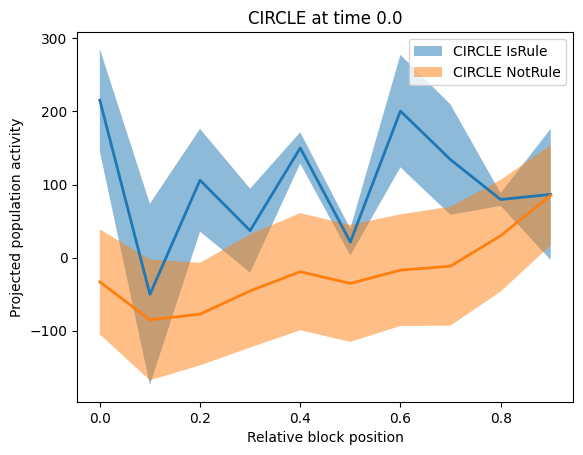

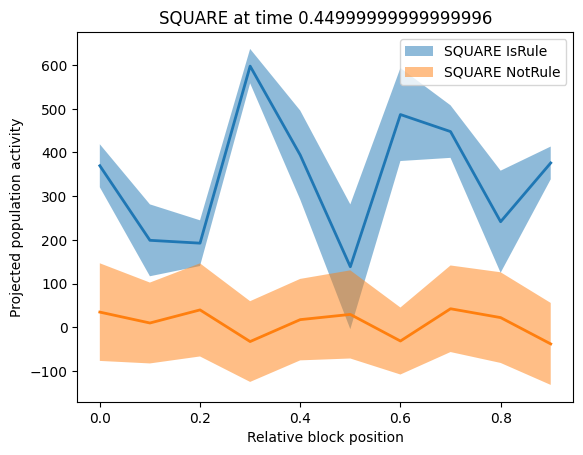

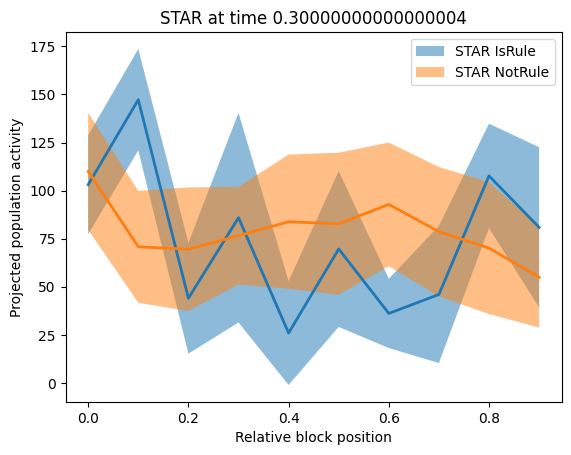

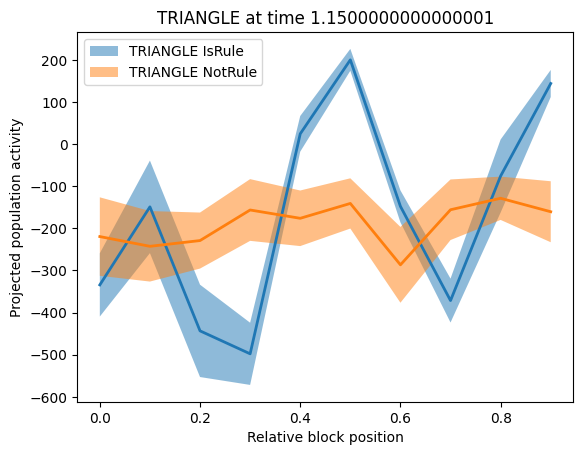

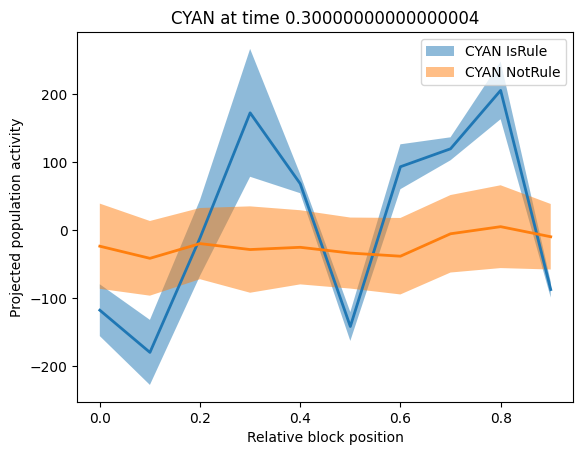

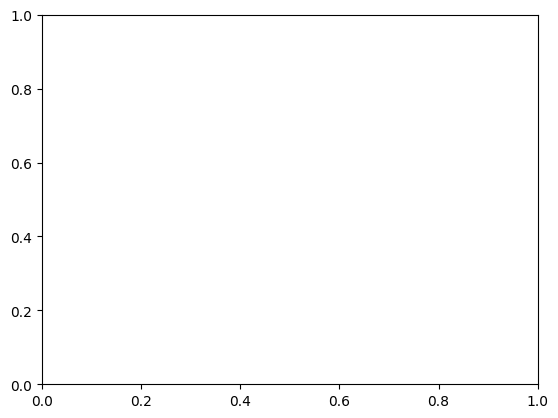

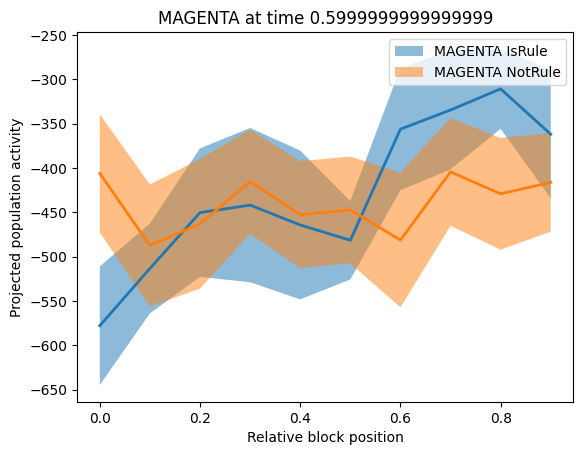

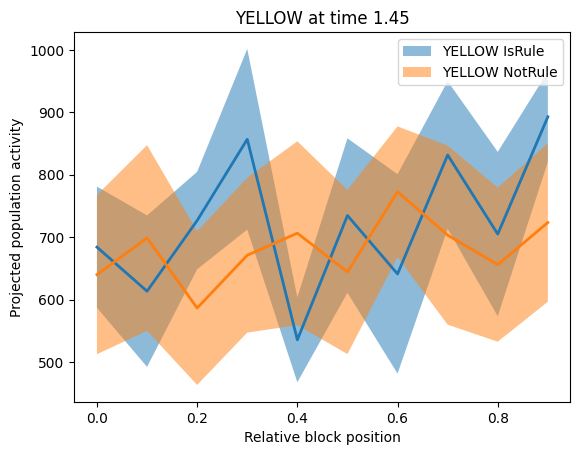

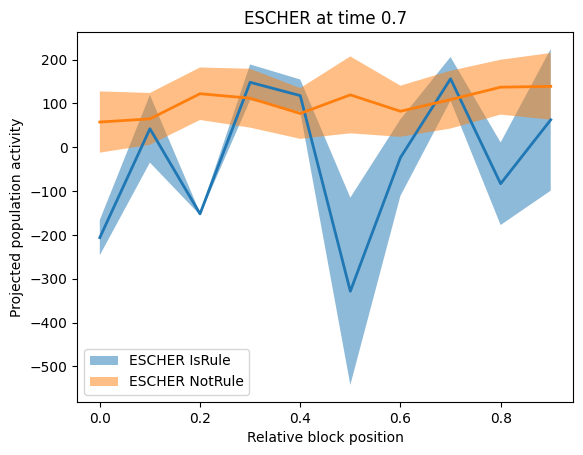

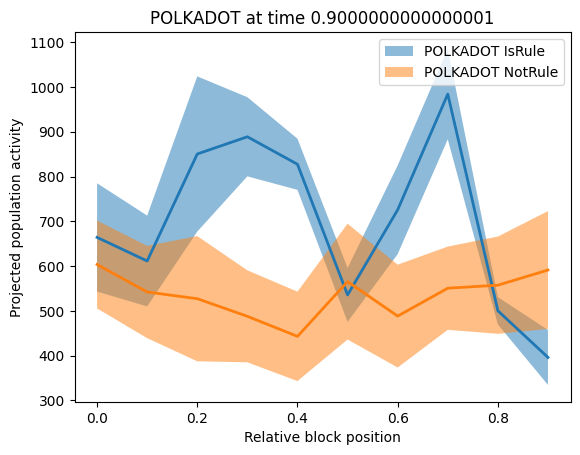

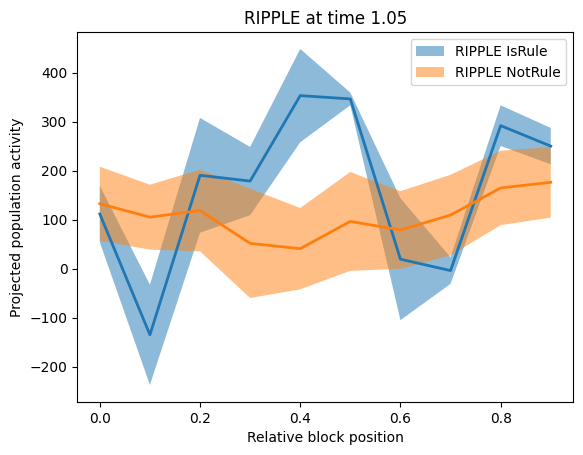

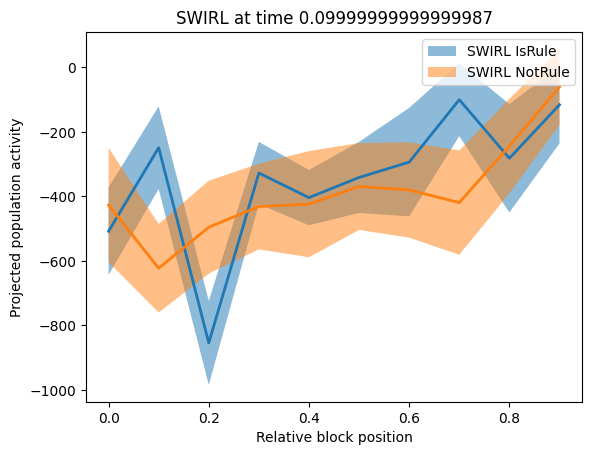

In [16]:
# fig, axs = plt.subplots(3, 4, figsize=(20, 10))

for i, feat in enumerate(FEATURES):
    # ax = axs[int(i / 4), i % 4]
    fig, ax = plt.subplots()

    time_idx, cor = find_best_time_correlation(glm_res, feat, frs, valid_beh)
    # time_idx = 39
    time_bin = time_idx / 20
    time = time_bin - 1.3
    feat_dim = FEATURE_TO_DIM[feat]
    vec = glm_res[glm_res.TimeIdxs == time_idx].sort_values(by="UnitID")[feat + "Value_coef"].values
    # valid_beh = valid_beh[valid_beh[feat_dim] == feat]

    time_frs = frs[np.isclose(frs.TimeBins, time_bin)]
    projections = project_to_axes(time_frs, vec)

    merged = pd.merge(projections, valid_beh, on="TrialNumber")
    is_rule = merged[merged.CurrentRule == feat]
    not_rule = merged[merged.CurrentRule != feat]

    if len(is_rule) == 0: 
        continue

    plot_mean_sterrs(is_rule, ax, f"{feat} IsRule", num_block_bins)
    plot_mean_sterrs(not_rule, ax, f"{feat} NotRule", num_block_bins)
    # ax.set_title(f"{feat} best time bin: {round(time, 3)}, cor {round(cor, 3)}")
    ax.set_title(f"{feat} at time {time}")

In [232]:
feat = "TRIANGLE"
# time_idx = find_best_time_max_norm(glm_res, feat)
time_idx, cor = find_best_time_correlation(glm_res, feat, frs, valid_beh)
# time_idx = 36
# time_idx = 46
# time_idx = 6
time_bin = time_idx / 20
time = time_bin - 1.3
print(f"Best time bin: {time}, cor {cor}")

Best time bin: 0.6499999999999999, cor 0.17941047372662078


In [233]:
# time = 1
# time_bin = time + 1.3
# time_idx = int((time_bin) * 20)
# feat = "GREEN"
feat_dim = FEATURE_TO_DIM[feat]
vec = glm_res[glm_res.TimeIdxs == time_idx].sort_values(by="UnitID")[feat + "Value_coef"].values

In [234]:
num_block_bins = 10
valid_beh = behavioral_utils.get_relative_block_position(valid_beh, num_block_bins)
# valid_beh = valid_beh[valid_beh[feat_dim] == feat]

time_frs = frs[np.isclose(frs.TimeBins, time_bin)]
projections = project_to_axes(time_frs, vec)

merged = pd.merge(projections, valid_beh, on="TrialNumber")

/src/wcst_decode/utils/behavioral_utils.py:443: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  beh = beh.groupby("BlockNumber").apply(get_block_lengths).reset_index()


In [235]:
is_rule = merged[merged.CurrentRule == feat]
not_rule = merged[merged.CurrentRule != feat]

In [236]:
is_rule.BlockPositionBin.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

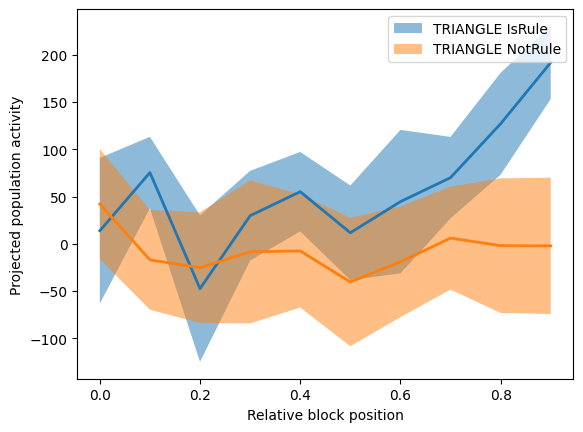

In [237]:


# fig, ax = plt.subplots(1, 1, figsize=(10, 3), sharey=True)
fig, ax = plt.subplots()

plot_mean_sterrs(is_rule, ax, f"{feat} IsRule", num_block_bins)
plot_mean_sterrs(not_rule, ax, f"{feat} NotRule", num_block_bins)